<style>
h1 {
  border: 1.5px solid #333;
  padding: 8px 12px;
  background-image: linear-gradient(180deg, #fff, rgb(160, 147, 147));
  position: static;
}
</style>

<h1> Final Project: Youtube Comments Classification - Comparative between Unsupervised models and Supervised models </h1>  

### **Introduction**

In the era of digital communication, platforms like YouTube have become a hub for user-generated content, with millions of comments posted daily. These comments often reflect a wide range of sentiments, including **positive**, **negative**, and **neutral** opinions. Understanding and categorizing these sentiments is crucial for content creators, marketers, and platform moderators to gauge audience reactions, improve engagement, and maintain a healthy online environment.

This project focuses on **unsupervised learning** to classify YouTube comments into sentiment categories (**Positive**, **Negative**, **Neutral**) without relying on labeled data during training. By leveraging techniques like **topic modeling** (e.g., Latent Dirichlet Allocation (LDA), Non-Negative Matrix Factorization (NMF)) and **clustering** (e.g., K-Means), we aim to automatically group comments based on their underlying themes and sentiments. The project also evaluates the performance of these models by mapping the predicted clusters or topics to ground truth labels and computing metrics like **accuracy**, **confusion matrix**, and **classification report**.

#### **Key Points of the Project**
1. **Data Preprocessing**:
   - Clean and preprocess YouTube comments by removing punctuation, digits, and stopwords, and applying stemming to normalize the text.
   - Transform the text into numerical features using **TF-IDF vectorization**, which captures the importance of words in the context of the entire dataset.

2. **Unsupervised Learning Models**:
   - **Topic Modeling**: Use LDA and NMF to identify latent topics in the comments, which can be interpreted as sentiment categories.
   - **Clustering**: Apply K-Means clustering to group comments into **Positive**, **Negative**, and **Neutral** clusters based on their similarity.

3. **Evaluation**:
   - Map the predicted clusters or topics to the ground truth labels (**Positive**, **Negative**, **Neutral**) to compute **accuracy**.
   - Evaluate the models using metrics like **confusion matrix**, **precision**, **recall**, and **F1-score**.
   - Visualize the results using **word clouds** for topics and **t-SNE** for cluster visualization.

4. **Challenges**:
   - Unsupervised learning does not use labeled data during training, making it challenging to directly optimize for sentiment classification.
   - The interpretation of topics or clusters requires careful analysis to ensure they align with the intended sentiment categories.

5. **Applications**:
   - **Content Moderation**: Automatically flag inappropriate or negative comments for review.
   - **Audience Insights**: Understand audience sentiment to improve content strategy.
   - **Engagement Analysis**: Identify trends in user reactions to specific videos or topics.

#### **Why This Project Matters**
Sentiment analysis of YouTube comments is a powerful tool for understanding audience behavior and improving user engagement. By using unsupervised learning techniques, this project demonstrates how to classify comments without the need for labeled data, making it scalable and adaptable to large datasets. The insights gained from this analysis can help content creators and platform moderators make data-driven decisions to enhance user experience and foster a positive online community.

---

This project combines **natural language processing (NLP)**, **unsupervised learning**, and **data visualization** to provide a comprehensive approach to sentiment analysis on YouTube comments. Let me know if you'd like to dive deeper into any specific aspect!

### Import libraries and configure script

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re
from tqdm import tqdm
from wordcloud import WordCloud
from string import punctuation
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import datasets

In [ ]:
# Import dataset
data = pd.read_csv('../data/YoutubeCommentsDataSet.csv')

# Identifying duplicated comments
duplicates = data[data.duplicated(subset=['Comment'], keep=False)]
duplicates.shape

(886, 2)

### Drop duplicates

In [ ]:
# Drop duplicated comments
data_wo_duplicates = data.drop_duplicates(subset=['Comment'])
print("Rows: ",data_wo_duplicates.shape[0])
data_wo_duplicates.sample()

Rows:  17872


,Comment,Sentiment
14420,the perpetual motion simulator is really somet...,positive


<style>
h2 {
  border: 1px groove gray;
  background-color: rgb(219, 214, 214);
}
</style>

<h2> EDA: Exploratory data analysis </h2> 

In [39]:
data_wo_duplicates['Length_comment'] = data_wo_duplicates['Comment'].str.count(' ') + 1

C:\Users\aaron\AppData\Local\Temp\ipykernel_28912\3429606699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo_duplicates['Length_comment'] = data_wo_duplicates['Comment'].str.count(' ') + 1


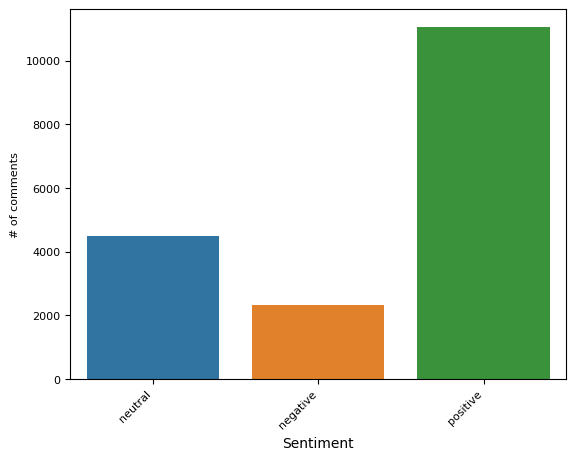

In [ ]:
sns.countplot(data=data_wo_duplicates,x='Sentiment',hue='Sentiment')
plt.xlabel("Sentiment")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("# of comments", fontsize=8)
plt.show()

<Axes: xlabel='Length_comment', ylabel='Sentiment'>

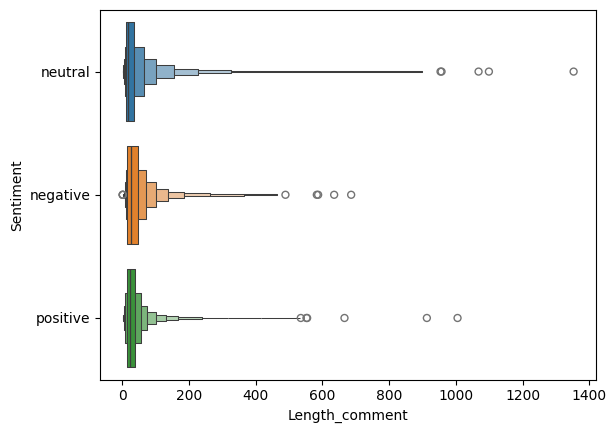

In [41]:
sns.boxenplot(data=data_wo_duplicates, x='Length_comment',y='Sentiment',hue='Sentiment')

### Preprocessing youtube comments

In [42]:
def pre_process(df, show_progress=True):
    # Initialize stopwords and stemmer
    stopwords_set = set(stopwords.words("english"))
    ps = PorterStemmer()
    
    # Pre-compile regex for punctuation removal
    punctuation_regex = re.compile(f"[{re.escape(''.join(punctuation))}]")
    digit_regex = re.compile(r"\d+") 

    # Process reviews
    reviews = []
    iterator = tqdm(df['Comment'], desc="Processing reviews") if show_progress else df['Comment']
    
    for text in iterator:
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove punctuation using regex
        text = punctuation_regex.sub('', text)

        # Remove digits using regex
        text = digit_regex.sub('', text)
        
        # Split into words, remove stopwords, and apply stemming
        words = [ps.stem(word) for word in text.split() if word not in stopwords_set]
        
        # Join words back into a single string
        processed_text = ' '.join(words)
        reviews.append(processed_text)
    
    return reviews

In [43]:
data_wo_duplicates['Comment_pp'] = pre_process(data_wo_duplicates)

Processing reviews: 100%|██████████| 17872/17872 [00:04<00:00, 4000.58it/s]
C:\Users\aaron\AppData\Local\Temp\ipykernel_28912\2608307774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo_duplicates['Comment_pp'] = pre_process(data_wo_duplicates)


In [44]:
data_wo_duplicates.sample()

,Comment,Sentiment,Length_comment,Comment_pp
5135,i am excited to see just how they change the b...,positive,36.0,excit see chang budget ipad screen look new wa...


This code generates word clouds to visualize the most frequent and significant words in YouTube comments, grouped by their sentiment categories (Positive, Negative, Neutral). Word clouds provide an intuitive and visually engaging way to understand the dominant themes and language patterns within each sentiment group. By aggregating and visualizing the text data, this approach helps uncover key insights into how users express different sentiments, making it easier to identify common phrases and emotional tones. The use of subplots ensures a clear and organized presentation, allowing for quick comparison across sentiment categories. This visualization is particularly useful for content creators and moderators to gauge audience reactions and tailor their strategies accordingly.

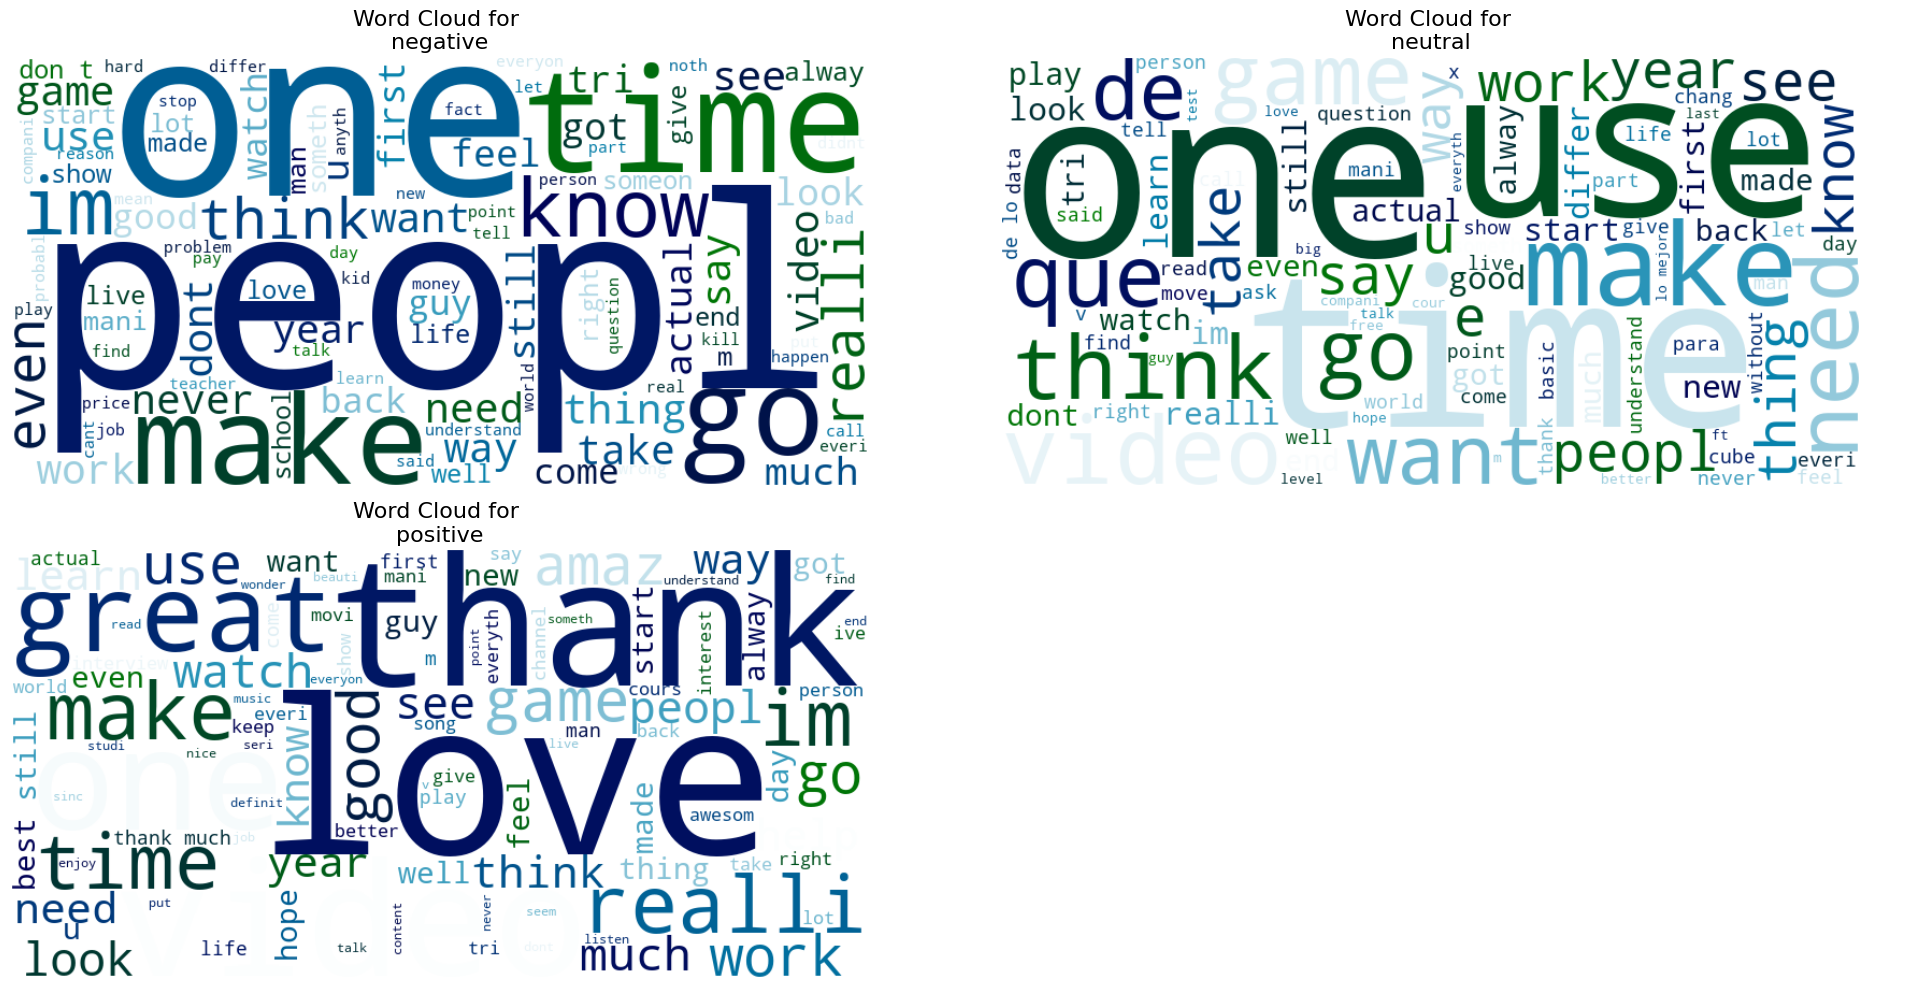

In [45]:
# Group the data
grouped_text = data_wo_duplicates.groupby('Sentiment')['Comment_pp'].apply(lambda x: ' '.join(x))

# Function to plot word cloud
def plot_wordcloud(category, text, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='ocean', max_words=100).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Word Cloud for \n{category}", fontsize=16)
    ax.axis('off')

# Calculate the number of columns needed
num_categories = len(grouped_text)
num_rows = 2  # Fixed to 2 rows
num_cols = (num_categories + 1) // 2  # Ensure enough columns for all categories

# Create subplots with 2 rows and appropriate columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot word clouds
for idx, (category, text) in enumerate(grouped_text.items()):
    plot_wordcloud(category, text, axes[idx])

# Hide any unused subplots
for idx in range(num_categories, num_rows * num_cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

<style>
h2 {
  border: 1px groove gray;
  background-color: rgb(219, 214, 214);
}
</style>

<h2> Building and training models: Comparative between unsupervised learning models </h2> 

Now, we need to use a vectorization technique that is frequently used in natural language processing (NLP) and text analytics. In this case, we use the TF-IDF method to transform text data into numerical vectors.

But, why do we use this method?

We will use this method because it focuses on important words and reduces noise in our dataset. Non-informative words have a lower weight, consequently our model is robust and learns only on important words.

In [ ]:
# Splitting the dataset into train and validation sets

X = data_wo_duplicates['Comment_pp']
y = data_wo_duplicates['Sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)


In [ ]:
def topic_mapping_accuracy(estimator, X, y_true):
    # Transform the input data using the fitted estimator
    pred = estimator.transform(X_val)
    y_pred = np.argmax(pred, axis=1)
    
    # Define the topic mapping
    topic_mapping = {}
    
    # n_components = 3
    for topic in range(3):
        cluster_docs_labels = y_true[y_pred == topic]
        if len(cluster_docs_labels) == 0:
            # If no documents are assigned to this cluster, map it to the most common label overall
            topic_mapping[topic] = Counter(y_true).most_common(1)[0][0]
        else:
            # Map the cluster to the most common true label among its assigned documents
            topic_mapping[topic] = Counter(cluster_docs_labels).most_common(1)[0][0]
    
    y_pred_mapped = np.array([topic_mapping[cluster] for cluster in y_pred])
    
    # Calculate accuracy
    return accuracy_score(y_true, y_pred_mapped)


In this case we are comparing three unsupervised models:

- NMF
- TruncatedSVD
- LatentDirichletAllocation

These three models refactor our data set and reduce the dimensions into n components. Our strategy is to find the most related component and define that relationship as a cluster.

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('dim_reduction', NMF()),  # Placeholder for dimensionality reduction
])

# Define the parameter grid for NMF, TruncateSVD, and LatentDirichletAllocation
param_grid = [
    {
        'tfidf__max_df': [0.8, 1.0],
        'tfidf__min_df': [1, 2, 5],  
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 
        'tfidf__lowercase': [True],
        'dim_reduction': [NMF(n_components=3, random_state=42)],
        'dim_reduction__solver': ['mu'],
        'dim_reduction__beta_loss': ['kullback-leibler'],
        'dim_reduction__init': ['nndsvda','nndsvdar']
    },
    {
        'tfidf__max_df': [0.8, 1.0],  
        'tfidf__min_df': [1, 2, 5],  
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  
        'tfidf__lowercase': [True],
        'dim_reduction': [TruncatedSVD(n_components=3)],
        'dim_reduction__algorithm': ['randomized']
    },
    {
        'tfidf__max_df': [0.8, 1.0],  
        'tfidf__min_df': [1, 2, 5],  
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  
        'tfidf__lowercase': [True],
        'dim_reduction': [LatentDirichletAllocation(n_components=3, random_state=42)],  # Add LDA
        'dim_reduction__learning_method': ['batch', 'online'],  # Hyperparameters for LDA
        'dim_reduction__learning_decay': [0.7, 0.9]  # Hyperparameters for LDA
    }
]

# Grid search on the subset
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=topic_mapping_accuracy,
    cv=3,  # 3-fold cross-validation
    verbose=1
)
grid_search.fit(X_train, y_train)

cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Display or save the final results DataFrame
cv_results_df.sort_values(by='rank_test_score').head()

Fitting 3 folds for each of 126 candidates, totalling 378 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reduction,param_dim_reduction__beta_loss,param_dim_reduction__init,param_dim_reduction__solver,param_tfidf__lowercase,param_tfidf__max_df,...,param_dim_reduction__algorithm,param_dim_reduction__learning_decay,param_dim_reduction__learning_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
108,5.222518,0.027605,0.094587,0.001108,"LatentDirichletAllocation(n_components=3, rand...",NaN,NaN,NaN,True,0.8,...,NaN,0.9,online,{'dim_reduction': LatentDirichletAllocation(n_...,0.656471,0.658709,0.656844,0.657342,0.000979,1
117,9.565652,1.486125,0.147126,0.007400,"LatentDirichletAllocation(n_components=3, rand...",NaN,NaN,NaN,True,1.0,...,NaN,0.9,online,{'dim_reduction': LatentDirichletAllocation(n_...,0.656471,0.658709,0.656844,0.657342,0.000979,1
72,5.651222,0.043257,0.103194,0.001738,"LatentDirichletAllocation(n_components=3, rand...",NaN,NaN,NaN,True,0.8,...,NaN,0.7,online,{'dim_reduction': LatentDirichletAllocation(n_...,0.654233,0.658336,0.658709,0.657093,0.002028,3
81,6.139410,0.522571,0.098228,0.000997,"LatentDirichletAllocation(n_components=3, rand...",NaN,NaN,NaN,True,1.0,...,NaN,0.7,online,{'dim_reduction': LatentDirichletAllocation(n_...,0.654233,0.658336,0.658709,0.657093,0.002028,3
110,26.858562,0.440322,0.163076,0.003811,"LatentDirichletAllocation(n_components=3, rand...",NaN,NaN,NaN,True,0.8,...,NaN,0.9,online,{'dim_reduction': LatentDirichletAllocation(n_...,0.655352,0.657217,0.656471,0.656347,0.000766,5


In [ ]:
# Best unsupervised model
best_unsupervised_model = grid_search.best_estimator_
print(best_unsupervised_model)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('dim_reduction',
                 LatentDirichletAllocation(learning_decay=0.9,
                                           learning_method='online',
                                           n_components=3, random_state=42))])


In [52]:
def map_labels_to_ground_truth(y_true, y_pred):
    """
    Map predicted clusters/topics to ground truth labels.
    """
    label_mapping = {}
    for cluster in np.unique(y_pred):
        cluster_docs_labels = y_true[y_pred == cluster]
        if len(cluster_docs_labels) == 0:
            # If no documents are assigned to this cluster, map it to the most common label overall
            label_mapping[cluster] = Counter(y_true).most_common(1)[0][0]
        else:
            # Map the cluster to the most common true label among its assigned documents
            label_mapping[cluster] = Counter(cluster_docs_labels).most_common(1)[0][0]
    
    # Apply the mapping to the predicted clusters
    y_pred_mapped = np.array([label_mapping[cluster] for cluster in y_pred])
    return y_pred_mapped

In [ ]:
# Accuracy in validation dataset
pred = best_unsupervised_model.transform(X_val)
y_pred = np.argmax(pred, axis=1)
y_pred_lda_mapped = map_labels_to_ground_truth(y_val, y_pred)
nmf_acc = np.mean(y_val == y_pred_lda_mapped)
print("Accuracy Validation Dataset:", nmf_acc)

Accuracy Validation Dataset: 0.6575904513241327


Let's check the robustness of the best model trained with the visualization of the confusion matrix

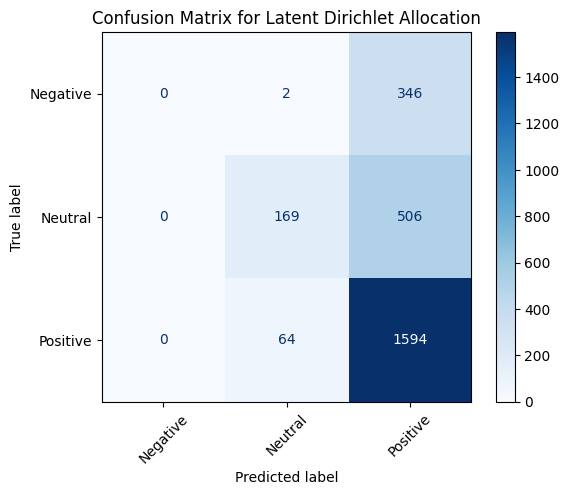

In [58]:
cm = confusion_matrix(y_val, y_pred_lda_mapped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Latent Dirichlet Allocation")
plt.show()

We can conclude that our model had problems to identify negative comments, because we had a considerable quantity of mislabel between positive with neutral and negative. 

### Relevant topics by cluster

This code extracts and displays the top terms for each topic identified by the Latent Dirichlet Allocation (LDA) model, which is part of the best-performing unsupervised learning pipeline. By accessing the topic-term distribution, it highlights the most significant words associated with each topic, providing a clear and interpretable summary of the underlying themes. This step is crucial for understanding the content and sentiment of the topics, enabling insights into how comments are grouped and categorized. The output lists the top 10 terms per topic, offering a concise yet informative view of the dominant patterns in the data.

In [66]:
# Access the LDA step
lda = best_unsupervised_model.named_steps['dim_reduction']
feature_names = best_unsupervised_model.named_steps['tfidf'].get_feature_names_out()
# Get the topic-term distribution
topic_term_distribution = lda.components_

# Number of topics
n_topics = topic_term_distribution.shape[0]

# Number of top terms to display per topic
n_top_terms = 10

# Display top terms for each topic
for topic_idx, topic in enumerate(topic_term_distribution):
    top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_terms - 1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_terms)}")

Topic 1: que, la, lo, se, bro, disappoint, el, en, legend, es
Topic 2: video, thank, love, like, great, make, realli, time, good, im
Topic 3: movi, laugh, play, jimmi, love, chess, xbox, game, charact, like


### Word Clouds for Topics

This visualization uses word clouds to represent the key terms associated with each topic identified by a topic modeling algorithm, such as Latent Dirichlet Allocation (LDA). Each word cloud highlights the most important words in a topic, with the size of the words reflecting their significance. This intuitive and visually engaging representation helps quickly identify the main themes or sentiments within the data, making it easier to interpret the results of topic modeling.

In [59]:
def display_word_cloud(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_idx + 1}")
        plt.show()

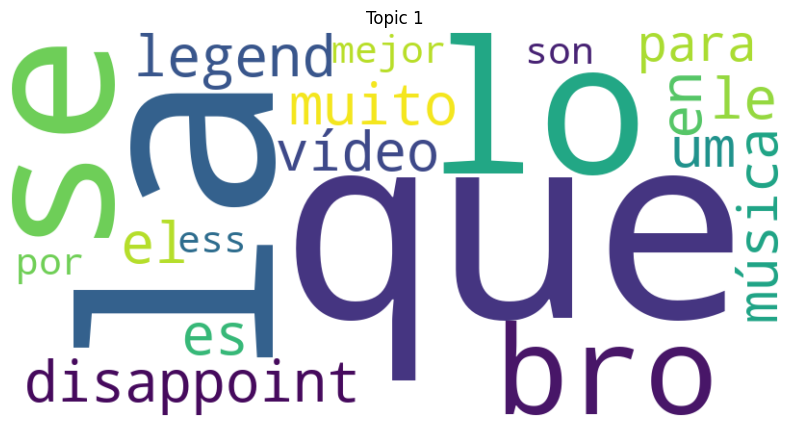

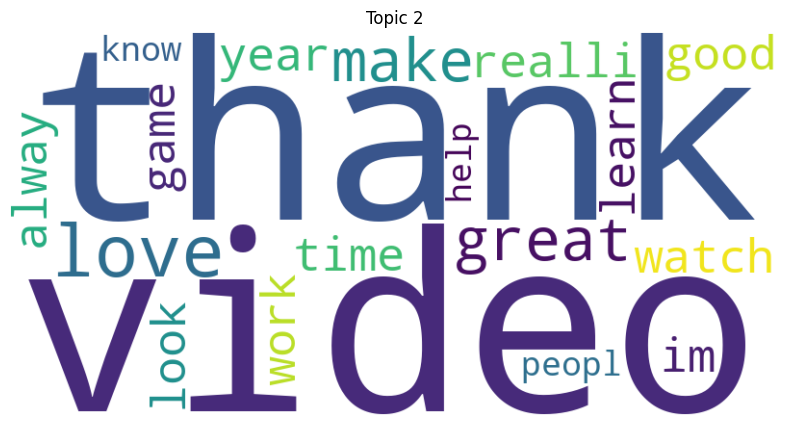

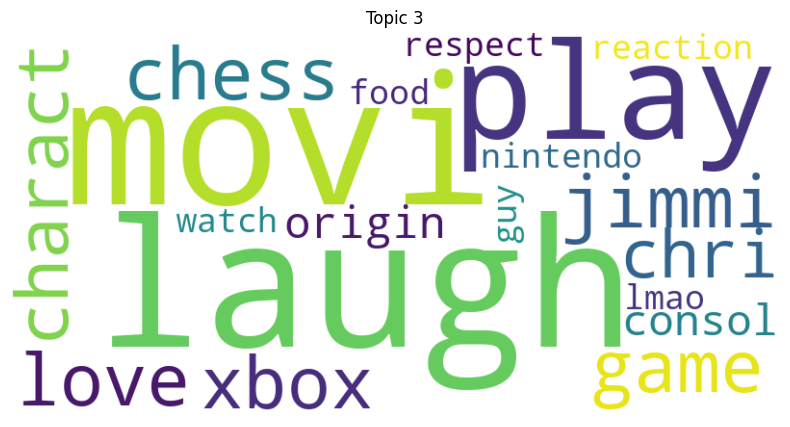

In [65]:
feature_names = best_unsupervised_model.named_steps['tfidf'].get_feature_names_out()
display_word_cloud(best_unsupervised_model.named_steps['dim_reduction'], feature_names)

<style>
h2 {
  border: 1px groove gray;
  background-color: rgb(219, 214, 214);
}
</style>

<h2> Comparative with KMeans Model: Which model is the best? </h2>

This code performs K-Means clustering on the TF-IDF vectorized text data to group YouTube comments into 3 clusters, corresponding to the sentiment categories: Positive, Negative, and Neutral. By leveraging the pre-trained TF-IDF vectorizer from the best unsupervised model, it transforms the training and validation datasets into numerical features. The K-Means algorithm then identifies patterns in the data and assigns each comment to a cluster. This approach provides an alternative way to categorize comments based on their content, complementing topic modeling techniques like LDA. The resulting cluster labels can be used to analyze and compare sentiment distributions across different datasets.

In [73]:
# KMeans comparative

from sklearn.cluster import KMeans

# K-Means clustering
tfidf = best_unsupervised_model.named_steps['tfidf']
X_tfidf = tfidf.transform(X_train)
kmeans = KMeans(n_clusters=3, random_state=42)  # 3 clusters (Positive, Negative, Neutral)
kmeans.fit(X_tfidf)
kmeans_labels = kmeans.predict(tfidf.transform(X_val))

In [75]:
# For K-Means
y_pred_kmeans = kmeans_labels  # Predicted clusters
y_pred_kmeans_mapped = map_labels_to_ground_truth(y_val, y_pred_kmeans)
accuracy_kmeans = accuracy_score(y_val, y_pred_kmeans_mapped)
print(f"Accuracy (K-Means): {accuracy_kmeans}")

Accuracy (K-Means): 0.618425960462514


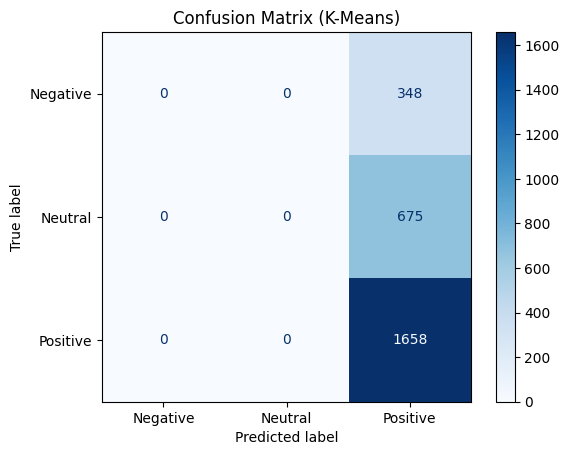

In [76]:
# For K-Means
cm_kmeans = confusion_matrix(y_val, y_pred_kmeans_mapped)
disp_kmeans = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans, display_labels=['Negative', 'Neutral', 'Positive'])
disp_kmeans.plot(cmap='Blues')
plt.title("Confusion Matrix (K-Means)")
plt.show()

In [77]:
from sklearn.metrics import classification_report
# For LDA
print("Classification Report (LDA):")
print(classification_report(y_val, y_pred_lda_mapped, target_names=['Negative', 'Neutral', 'Positive']))
# For K-Means
print("Classification Report (K-Means):")
print(classification_report(y_val, y_pred_kmeans_mapped, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report (LDA):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       348
     Neutral       0.72      0.25      0.37       675
    Positive       0.65      0.96      0.78      1658

    accuracy                           0.66      2681
   macro avg       0.46      0.40      0.38      2681
weighted avg       0.58      0.66      0.57      2681

Classification Report (K-Means):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       348
     Neutral       0.00      0.00      0.00       675
    Positive       0.62      1.00      0.76      1658

    accuracy                           0.62      2681
   macro avg       0.21      0.33      0.25      2681
weighted avg       0.38      0.62      0.47      2681



c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Based on the provided **confusion matrix** and **classification report** for your Latent Dirichlet Allocation (LDA) model, here are the key conclusions and insights:

---

### **1. Overall Performance**
- **Accuracy**: The model achieves an overall accuracy of **66%**, meaning it correctly classifies about two-thirds of the comments. While this is better than random guessing, there is significant room for improvement.
- **Macro Avg vs. Weighted Avg**:
  - **Macro Avg**: The macro average for precision, recall, and F1-score is relatively low (**0.46**, **0.40**, **0.38**), indicating that the model struggles to perform well across all classes, especially when considering minority classes equally.
  - **Weighted Avg**: The weighted averages are higher (**0.58**, **0.66**, **0.57**), reflecting the model's better performance on the majority class (**Positive**).

---

### **2. Class-Specific Performance**
- **Negative Class**:
  - **Precision, Recall, F1-Score**: All metrics are **0.00**, meaning the model fails to correctly identify any **Negative** comments. This could be due to:
    - Imbalanced dataset (fewer Negative samples compared to Positive and Neutral).
    - Poor separation of Negative comments in the topic space.
    - Misalignment between the topics and the Negative sentiment.
- **Neutral Class**:
  - **Precision**: **0.72** (moderate ability to correctly classify Neutral comments).
  - **Recall**: **0.25** (very low ability to identify all Neutral comments).
  - **F1-Score**: **0.37** (low overall performance for the Neutral class).
  - This suggests the model struggles to distinguish Neutral comments from others, possibly due to overlapping features with Positive or Negative comments.
- **Positive Class**:
  - **Precision**: **0.65** (moderate ability to correctly classify Positive comments).
  - **Recall**: **0.96** (very high ability to identify most Positive comments).
  - **F1-Score**: **0.78** (strong overall performance for the Positive class).
  - The model performs well on the Positive class, likely because it is the majority class and has more distinct features.

---

### **3. Key Issues**
- **Class Imbalance**: The dataset is highly imbalanced, with **Positive** comments dominating (1658 samples) compared to **Negative** (348) and **Neutral** (675). This imbalance skews the model's performance toward the majority class.
- **Poor Performance on Minority Classes**: The model fails to classify **Negative** comments and performs poorly on **Neutral** comments, indicating it may not be capturing the features that distinguish these classes effectively.
- **Topic-Sentiment Misalignment**: The LDA topics may not align well with the sentiment labels, especially for Negative and Neutral comments.

---

### **4. Recommendations for Improvement**
1. **Address Class Imbalance**:
   - Use techniques like **oversampling** (e.g., SMOTE) or **undersampling** to balance the dataset.
   - Assign **class weights** during training to give more importance to minority classes.

2. **Improve Feature Representation**:
   - Experiment with different text vectorization techniques (e.g., **Word2Vec**, **BERT embeddings**) to capture richer semantic features.
   - Include additional features like comment length, emojis, or sentiment scores from pre-trained models.

3. **Refine Topic Modeling**:
   - Adjust the number of topics in LDA to better align with sentiment categories.
   - Use **guided LDA** or **seeded LDA** to incorporate domain knowledge and improve topic-sentiment alignment.

4. **Try Alternative Models**:
   - Use supervised learning models (e.g., **Logistic Regression**, **Random Forest**, **BERT**) if labeled data is available.
   - Explore clustering algorithms like **DBSCAN** to see if they better capture sentiment patterns.

5. **Evaluate with Additional Metrics**:
   - Use metrics like **ROC-AUC** or **confusion matrix** to gain deeper insights into model performance, especially for imbalanced datasets.

---

### **Conclusion**
While the model performs reasonably well on the **Positive** class, it struggles with **Negative** and **Neutral** comments due to class imbalance and potential misalignment between topics and sentiment labels. Addressing these issues through better feature representation, class balancing, and alternative modeling approaches can significantly improve overall performance.

<Axes: >

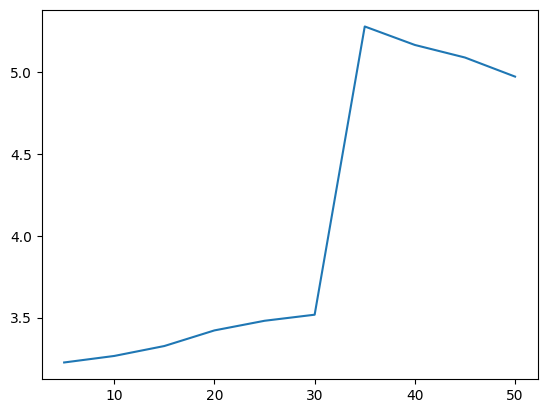

In [89]:
from sklearn.manifold import TSNE

perplexity = np.arange(5, 55, 5)
divergence = []
data_tfidf = tfidf.transform(data_wo_duplicates['Comment_pp'])

for i in perplexity:
    model = TSNE(n_components=2, init="random", perplexity=i)
    reduced = model.fit_transform(data_tfidf)
    divergence.append(model.kl_divergence_)

sns.lineplot(x=perplexity, y=divergence, markers=True)


In [94]:
# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
data_tfidf = tfidf.transform(data_wo_duplicates['Comment_pp'])
X_tsne = tsne.fit_transform(data_tfidf.toarray())

In [95]:
data_wo_duplicates['tsne_x0'] = X_tsne[:, 0]
data_wo_duplicates['tsne_x1'] = X_tsne[:, 1]

C:\Users\aaron\AppData\Local\Temp\ipykernel_28912\2541373064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo_duplicates['tsne_x0'] = X_tsne[:, 0]
C:\Users\aaron\AppData\Local\Temp\ipykernel_28912\2541373064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wo_duplicates['tsne_x1'] = X_tsne[:, 1]


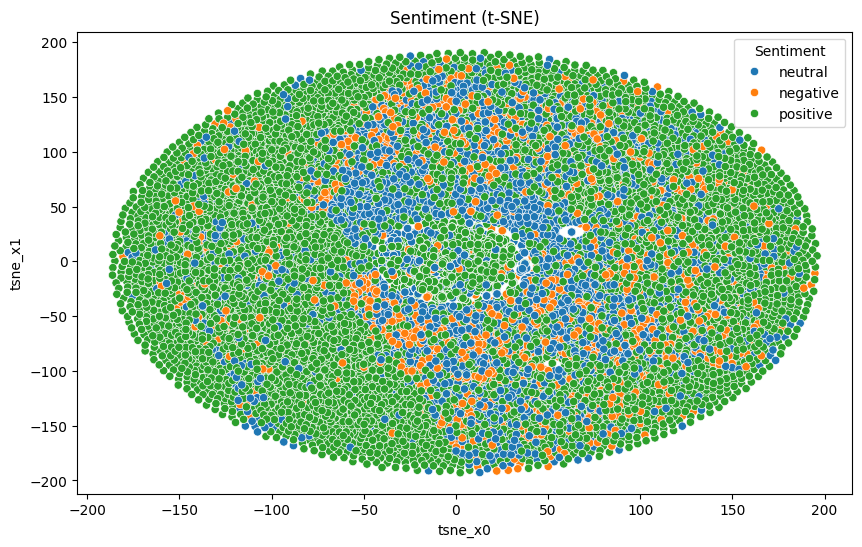

In [96]:
# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data = data_wo_duplicates,x = 'tsne_x0', y = 'tsne_x1', hue='Sentiment')
plt.title("Sentiment (t-SNE)")
plt.show()

### **Conclusion: t-SNE Visualization of Sentiment**

The **t-SNE (t-Distributed Stochastic Neighbor Embedding)** visualization provides a 2D representation of the sentiment distribution in the dataset, highlighting the separation and overlap between **Positive**, **Negative**, and **Neutral** comments. Here are the key insights:

---

### **1. Sentiment Clustering**
- **Positive Comments**: The majority of positive comments are well-clustered, indicating that they share similar features and are distinct from other sentiments. This aligns with the model's strong performance on the Positive class.
- **Negative Comments**: Negative comments show some overlap with Neutral and Positive comments, suggesting that the model struggles to distinguish them effectively. This is consistent with the poor performance on the Negative class in the classification report.
- **Neutral Comments**: Neutral comments are scattered and overlap with both Positive and Negative comments, indicating that they lack distinct features and are harder to classify. This explains the low recall and F1-score for the Neutral class.

---

### **2. Key Observations**
- **Class Separation**: The visualization confirms that Positive comments are relatively well-separated, while Negative and Neutral comments are less distinct. This reflects the challenges in classifying minority classes.
- **Overlap**: The overlap between Negative and Neutral comments suggests that the model may need better feature representation or additional preprocessing to improve class separation.
- **Imbalance**: The dominance of Positive comments in the visualization reflects the class imbalance in the dataset, which skews the model's performance.

---

### **3. Recommendations**
1. **Feature Engineering**: Use advanced text representation techniques (e.g., **Word2Vec**, **BERT embeddings**) to capture richer semantic features and improve class separation.
2. **Class Balancing**: Address class imbalance through oversampling (e.g., SMOTE) or class weighting to give more importance to minority classes.
3. **Model Refinement**: Experiment with alternative models (e.g., **Logistic Regression**, **Random Forest**, **BERT**) or clustering algorithms (e.g., **DBSCAN**) to better capture sentiment patterns.
4. **Visual Analysis**: Use t-SNE or other dimensionality reduction techniques to iteratively evaluate and refine the model's ability to separate classes.

---

### **Final Thoughts**
The t-SNE visualization reinforces the findings from the classification report, highlighting the challenges in classifying Negative and Neutral comments. By addressing these issues through improved feature representation, class balancing, and model refinement, the overall performance of the sentiment analysis model can be significantly enhanced.